# 2nd Derivative weighted loss function

Notebook exploring the development of a loss function that is weighted based on the second derivative.  

The second derivative has a large negative value at the stick -> slip transition and large positive value at the slip -> stick transition. A loss function weighted by the second derivative (with possible seperate weightings dependent on whether it is positive or negative) should help any ML model to prioritise learning to accurately forecast start and end of failures.

## Setup

In [25]:
# Import libraries
import sys
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import torch
import json
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

# Import local modules
from utils.dataset import SlowEarthquakeDataset
import utils.general_functions as gfn
from utils.data_preprocessing import moving_average_causal_filter, create_dataset, normalise_dataset

In [2]:
# Set random seed
SEED = 17 # random seed for the dataset and model
gfn.set_seed(SEED)

# Set torch device
device = gfn.set_torch_device()

No GPU available.


## Load data

In [3]:
# Define experiment list
EXPERIMENTS = [
    "cascadia",
    "p4679",
    "p4581",
    "b726",
    "b698",
    "i417",
    "sim_b726",
    "sim_b698",
    "sim_i417",
]

# Initialize the dataset loader with all experiments and load the data
dataset_loader = SlowEarthquakeDataset(EXPERIMENTS)
dataset_loader.load()

# Store all datasets in a single dataframe
df = {
    exp: dataset_loader.convert_to_df(exp)
    .rename(columns={"seg_avg" if exp == "cascadia" else "obs_shear_stress": "X"})[["X"]]
    for exp in EXPERIMENTS
}

## Standardised data pre-processing

In [27]:
# Get standardised downsampling and smoothing factors
with open("../conf.json", "r") as f:
    config = json.load(f)

config


{'cascadia': {'smoothing_window': 60, 'downsampling_factor': 1},
 'p4679': {'smoothing_window': 13, 'downsampling_factor': 13},
 'p4581': {'smoothing_window': 26, 'downsampling_factor': 26},
 'b726': {'smoothing_window': 1, 'downsampling_factor': 1},
 'b698': {'smoothing_window': 2, 'downsampling_factor': 2},
 'i417': {'smoothing_window': 2, 'downsampling_factor': 2},
 'sim_b726': {'smoothing_window': 1, 'downsampling_factor': 1},
 'sim_b698': {'smoothing_window': 2, 'downsampling_factor': 2},
 'sim_i417': {'smoothing_window': 2, 'downsampling_factor': 2}}

In [11]:
# Smooth and downsample
df_filtered = {
    exp: moving_average_causal_filter(df[exp], **config[exp])
    for exp in df
}

## Full dataset scaling

### Scaling

In [18]:
# Data scaling
scaler = MinMaxScaler()

df_filtered_sc = {
    exp: scaler.fit_transform(df_filtered[exp])
    for exp in df_filtered
}

### Visualise datasets

/home/users/jpoff/miniconda3/envs/gtc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/users/jpoff/miniconda3/envs/gtc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/users/jpoff/miniconda3/envs/gtc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/users/jpoff/miniconda3/envs/gtc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_in

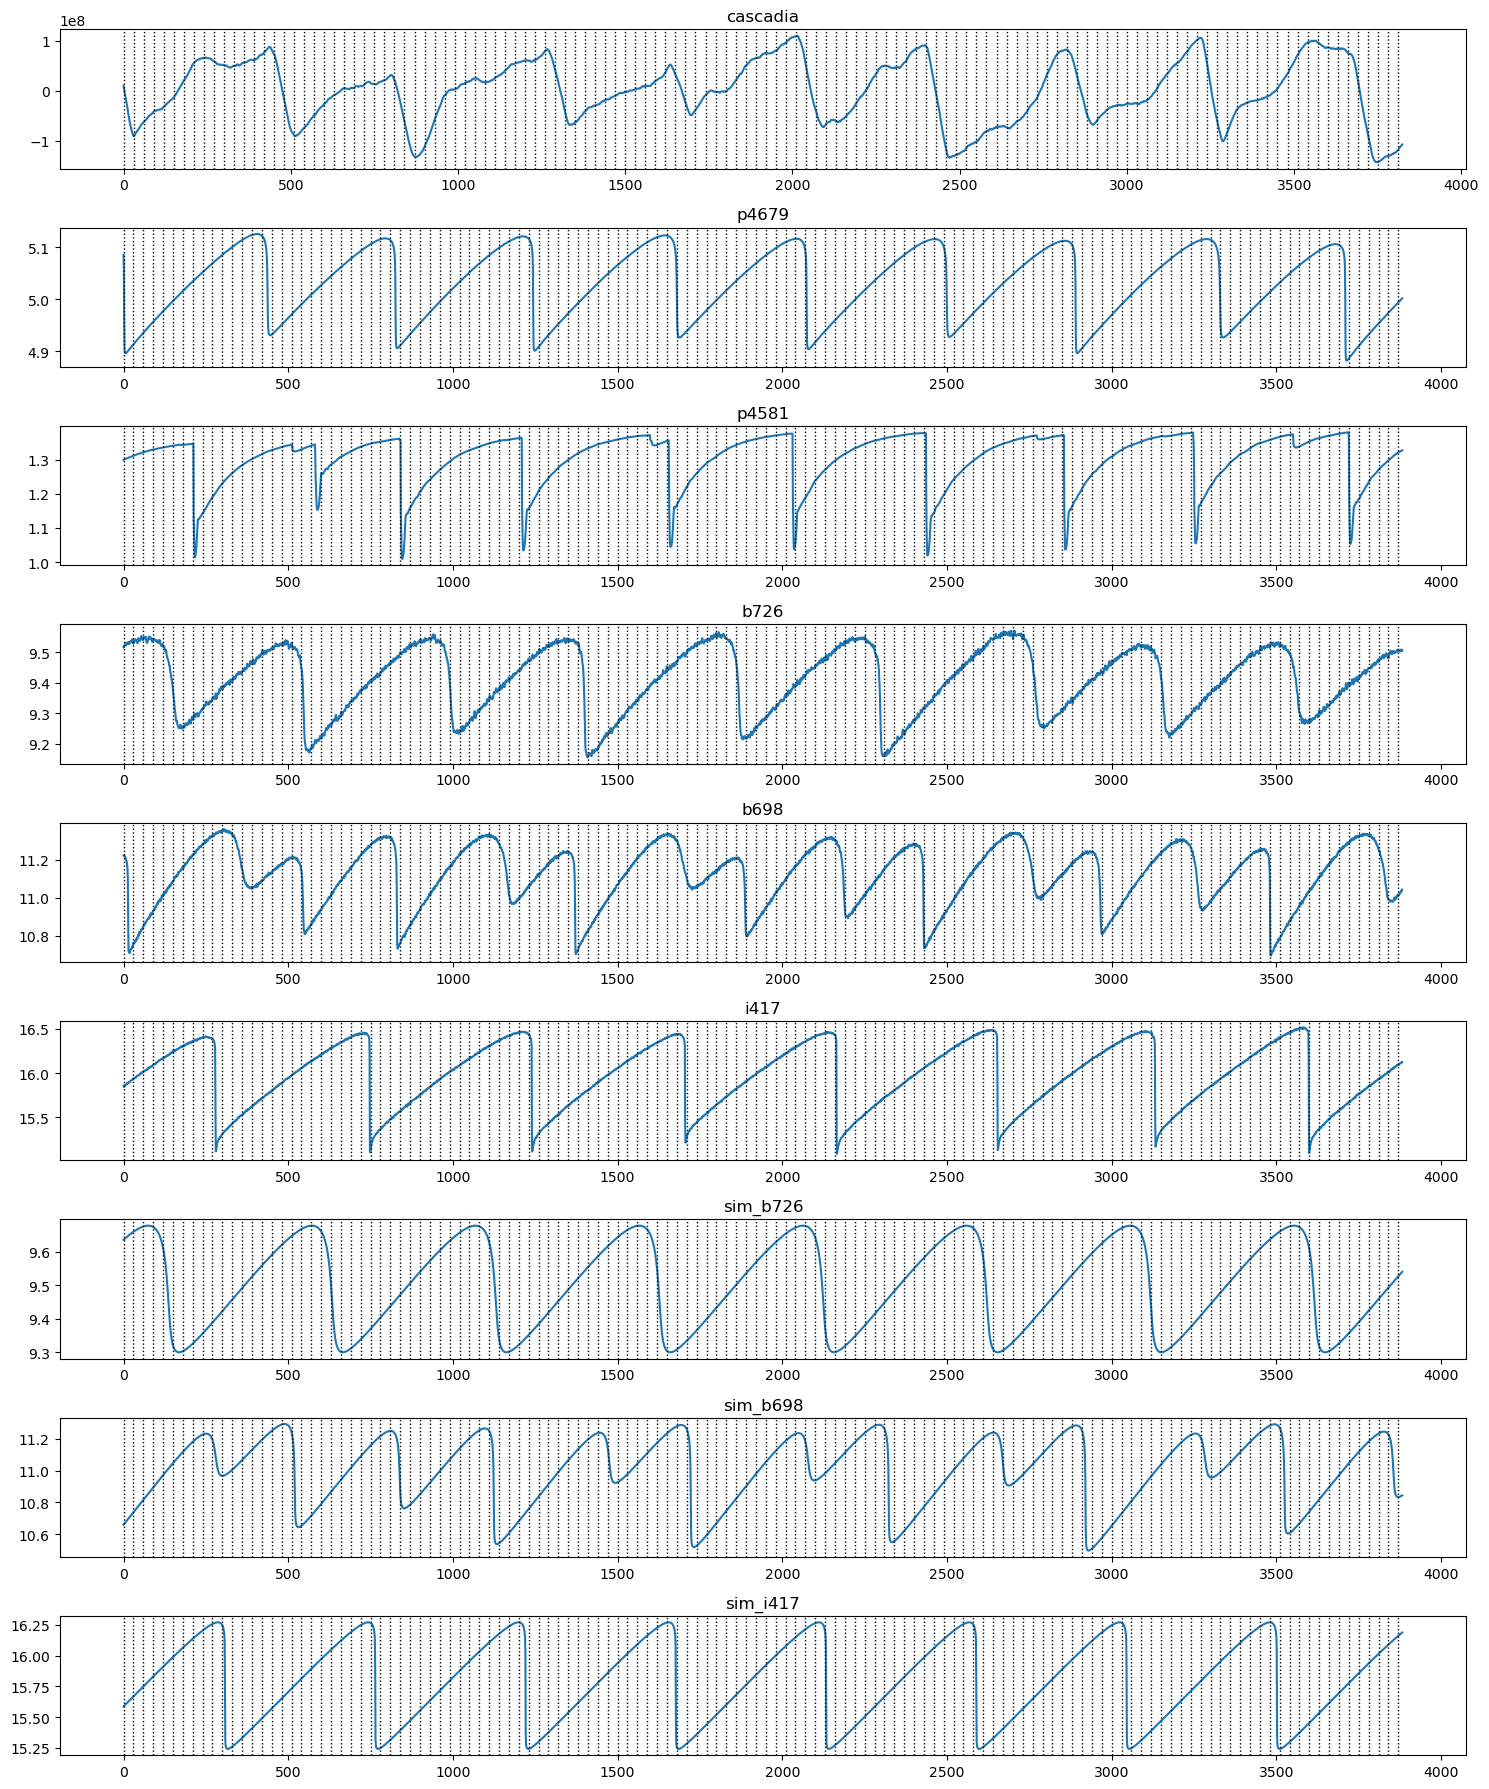

In [26]:
# Plot pre-processed data (smoothed and downsampled)

## Truncate length of all dataframes to match the length of 'cascadia' dataframe
cascadia_length = len(df["cascadia"])

df_truncated = {exp: df_exp.head(cascadia_length) for exp, df_exp in df_filtered.items()}

## Sort experiments to start with 'cascadia', then plot all data
sorted_experiments = ['cascadia'] + [exp for exp in EXPERIMENTS if exp != 'cascadia']

plt.figure(figsize=(15, len(sorted_experiments) * 2))
for i, exp in enumerate(sorted_experiments, 1):
    plt.subplot(len(sorted_experiments), 1, i)
    data = df_truncated[exp].reset_index()  # Reset index to ensure 'id' column exists
    sns.lineplot(data=data, x=data.index, y="X")  # Use the DataFrame index for x
    for x in np.arange(0, len(data), 30):
        plt.axvline(x=x, color='black', linestyle=':', linewidth=1)
    plt.title(exp)
    plt.ylabel('')
    plt.xlabel('')

plt.tight_layout()
plt.show()


In [32]:
df_filtered

{'cascadia':                  X
 0     1.023673e+07
 1     6.097137e+06
 2     2.621189e+06
 3    -1.059624e+06
 4    -5.242598e+06
 ...            ...
 3819 -1.102059e+08
 3820 -1.094695e+08
 3821 -1.087168e+08
 3822 -1.077935e+08
 3823 -1.067637e+08
 
 [3824 rows x 1 columns],
 'p4679':               X
 0      5.085234
 1      5.059466
 2      4.954753
 3      4.904778
 4      4.898534
 ...         ...
 23204  4.977631
 23205  4.978126
 23206  4.978690
 23207  4.979212
 23208  4.979797
 
 [23209 rows x 1 columns],
 'p4581':              X
 0     1.299007
 1     1.299420
 2     1.299856
 3     1.300342
 4     1.300845
 ...        ...
 7687  1.370045
 7688  1.370213
 7689  1.370272
 7690  1.370372
 7691  1.370730
 
 [7692 rows x 1 columns],
 'b726':               X
 0      9.515997
 1      9.519734
 2      9.517776
 3      9.523571
 4      9.522370
 ...         ...
 19996  9.390598
 19997  9.391377
 19998  9.389498
 19999  9.388610
 20000  9.388177
 
 [20001 rows x 1 columns],
 'b698':

In [33]:
df_filtered_sc

{'cascadia': array([[0.60553637],
        [0.58911148],
        [0.57531978],
        ...,
        [0.13355849],
        [0.13722177],
        [0.14130786]]),
 'p4679': array([[0.86525879],
        [0.7786622 ],
        [0.42675311],
        ...,
        [0.50719698],
        [0.50895265],
        [0.51091832]]),
 'p4581': array([[0.77954521],
        [0.78060072],
        [0.7817152 ],
        ...,
        [0.96164397],
        [0.96189949],
        [0.96281348]]),
 'b726': array([[0.82327562],
        [0.83146089],
        [0.82717353],
        ...,
        [0.54620069],
        [0.54425699],
        [0.54330858]]),
 'b698': array([[0.78405132],
        [0.7831208 ],
        [0.78076046],
        ...,
        [0.5435733 ],
        [0.53343478],
        [0.53800245]]),
 'i417': array([[0.53304682],
        [0.52365439],
        [0.52348109],
        ...,
        [0.9618064 ],
        [0.96149447],
        [0.96676256]]),
 'sim_b726': array([[0.8885408 ],
        [0.89084918],
        

In [31]:
# Plot scaled data

## Truncate length of all dataframes to match the length of 'cascadia' dataframe
cascadia_length = len(df["cascadia"])

df_truncated = {exp: df_exp.head(cascadia_length) for exp, df_exp in df_filtered_sc.items()}

## Sort experiments to start with 'cascadia', then plot all data
sorted_experiments = ['cascadia'] + [exp for exp in EXPERIMENTS if exp != 'cascadia']

plt.figure(figsize=(15, len(sorted_experiments) * 2))
for i, exp in enumerate(sorted_experiments, 1):
    plt.subplot(len(sorted_experiments), 1, i)
    data = df_truncated[exp].reset_index()  # Reset index to ensure 'id' column exists
    sns.lineplot(data=data, x=data.index, y="X")  # Use the DataFrame index for x
    for x in np.arange(0, len(data), 30):
        plt.axvline(x=x, color='black', linestyle=':', linewidth=1)
    plt.title(exp)
    plt.ylabel('')
    plt.xlabel('')

plt.tight_layout()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

## Full dataset derivatives

In [ ]:
# Additional smoothing - TODO: determine what optimal window should be



In [ ]:
# Calculate first derivative

In [ ]:
# Calculate second derivative

In [21]:
# Calculate weights based on second derivative (decisions on: scaled? exponential? ReLU?)


In [ ]:
# Visualise weights


## Windowed datasets

In [ ]:
# Create datasets (use create_dataset)

In [ ]:
# Data scaling (use normalise_dataset)

## Custom loss function

TODO: Finish the function

Additional inputs to add to function: 
- extra smoothing window (or just dataset name and have these defined in the function)
- derivative scaling parameters (again could have these defined in the function based on datatset name)


In [35]:
# Custom loss function based around Andrew's suggestions
def custom_loss1(y_true, y_pred):
    """
    Description
    """
    import torch
    import torch.nn as nn

    square_error = (y_true - y_pred)**2

    first_derivative = ...
    second_derivative = ...

    weights = ... # should depend on magnitude of exp or ReLU of second derivative

    weighted_loss = torch.mean(weights * square_error) # or torch.sum 

    return weighted_loss


Final TODO: Write this function as a script and with others work out how it is opererationalised in the existing training pipelines.